In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [71]:
df = pd.read_csv('Datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [72]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [73]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8026969481902059

# Accuracy and dummy model

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1131

In [10]:
(y_val == churn_decision).sum()/len(y_val)

0.8026969481902059

In [11]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [12]:
scores = []
for threshold in thresholds:
    churn_decision = (y_pred >= threshold)
    accuracy = (y_val == churn_decision).sum()/len(y_val)
    print('.%.2f : %.3f' %(threshold, accuracy))
    scores.append(accuracy)

.0.00 : 0.274
.0.05 : 0.510
.0.10 : 0.591
.0.15 : 0.666
.0.20 : 0.710
.0.25 : 0.738
.0.30 : 0.760
.0.35 : 0.773
.0.40 : 0.785
.0.45 : 0.793
.0.50 : 0.803
.0.55 : 0.801
.0.60 : 0.795
.0.65 : 0.786
.0.70 : 0.766
.0.75 : 0.744
.0.80 : 0.733
.0.85 : 0.726
.0.90 : 0.726
.0.95 : 0.726
.1.00 : 0.726


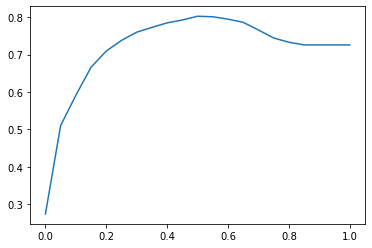

In [13]:
plt.plot(thresholds, scores)

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, churn_decision)

0.7260468417317246

# Confusion Matrix

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
t = 0.5
predict_positive = (y_pred >= t )
predict_negative = (y_pred < t )

In [18]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

In [19]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [20]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

In [21]:
confusion_matrix

array([[922, 101],
       [177, 209]])

In [22]:
# normalize

(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.13, 0.15]])

# Precision & recall

In [23]:
precision = tp / (tp+fp)
precision

0.6741935483870968

In [24]:
recall = tp / (tp+fn)
recall

0.5414507772020726

# ROC Curve

In [25]:
fpr = fp / (tn+fp)
tpr = tp / (fn+tp)

minimize fpr and maximize tpr

In [26]:
tpr, fpr

(0.5414507772020726, 0.09872922776148582)

In [27]:
thresholds = np.linspace(0, 1, 101)

scores = []

for threshold in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((threshold, tp, tn, fp, fn))

In [28]:
scores[:10]

[(0.0, 386, 0, 1023, 0),
 (0.01, 385, 112, 911, 1),
 (0.02, 384, 192, 831, 2),
 (0.03, 383, 257, 766, 3),
 (0.04, 381, 308, 715, 5),
 (0.05, 379, 340, 683, 7),
 (0.06, 377, 362, 661, 9),
 (0.07, 372, 381, 642, 14),
 (0.08, 371, 410, 613, 15),
 (0.09, 369, 442, 581, 17)]

In [29]:
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
scores_df = pd.DataFrame(scores, columns = columns)
scores_df.head()

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,112,911,1
2,0.02,384,192,831,2
3,0.03,383,257,766,3
4,0.04,381,308,715,5


In [30]:
scores_df[::10]

,threshold,tp,tn,fp,fn
0,0.0,386,0,1023,0
10,0.1,366,467,556,20
20,0.2,333,667,356,53
30,0.3,284,787,236,102
40,0.4,249,857,166,137
50,0.5,209,922,101,177
60,0.6,150,970,53,236
70,0.7,75,1004,19,311
80,0.8,11,1022,1,375
90,0.9,0,1023,0,386


In [31]:
scores_df['tpr'] = scores_df.tp / (scores_df.tp + scores_df.fn)
scores_df['fpr'] = scores_df.fp / (scores_df.fp + scores_df.tn)
scores_df.head()

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.00,386,0,1023,0,1.000000,1.000000
1,0.01,385,112,911,1,0.997409,0.890518
2,0.02,384,192,831,2,0.994819,0.812317
3,0.03,383,257,766,3,0.992228,0.748778
4,0.04,381,308,715,5,0.987047,0.698925


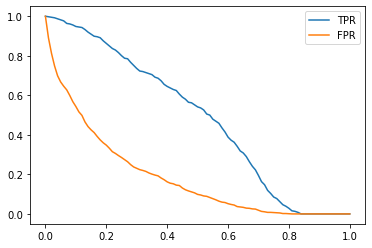

In [32]:
plt.plot(scores_df.threshold, scores_df.tpr, label='TPR')
plt.plot(scores_df.threshold, scores_df.fpr, label='FPR')
plt.legend()

## Random Model

In [33]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [34]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [35]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for threshold in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= threshold)
        predict_negative = (y_pred < threshold)
        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((threshold, tp, tn, fp, fn))
        
    columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    scores_df = pd.DataFrame(scores, columns = columns)

    scores_df['tpr'] = scores_df.tp / (scores_df.tp + scores_df.fn)
    scores_df['fpr'] = scores_df.fp / (scores_df.fp + scores_df.tn)

    return scores_df

In [36]:
scores_df_random  = tpr_fpr_dataframe(y_val, y_rand)
scores_df_random.head()

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.00,386,0,1023,0,1.000000,1.000000
1,0.01,382,10,1013,4,0.989637,0.990225
2,0.02,379,30,993,7,0.981865,0.970674
3,0.03,375,44,979,11,0.971503,0.956989
4,0.04,372,54,969,14,0.963731,0.947214


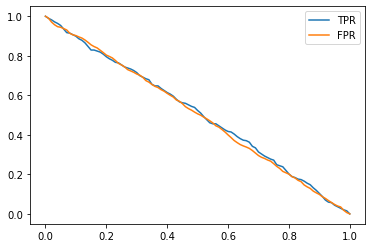

In [37]:
plt.plot(scores_df_random.threshold, scores_df_random.tpr, label='TPR')
plt.plot(scores_df_random.threshold, scores_df_random.fpr, label='FPR')
plt.legend()

## Ideal Model

In [38]:
num_pos = (y_val == 1).sum()
num_neg = (y_val == 0).sum()

In [39]:
num_pos, num_neg

(386, 1023)

In [40]:
y_ideal = np.repeat((0,1), [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [41]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [42]:
1 - y_val.mean()

0.7260468417317246

In [43]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [44]:
scores_df_ideal  = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
scores_df_ideal.head()

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.00,386,0,1023,0,1.0,1.000000
1,0.01,386,15,1008,0,1.0,0.985337
2,0.02,386,29,994,0,1.0,0.971652
3,0.03,386,43,980,0,1.0,0.957967
4,0.04,386,57,966,0,1.0,0.944282


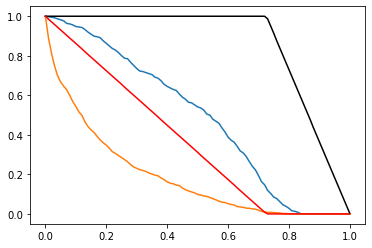

In [45]:
plt.plot(scores_df.threshold, scores_df.tpr, label='TPR')
plt.plot(scores_df.threshold, scores_df.fpr, label='FPR')

plt.plot(scores_df_ideal.threshold, scores_df_ideal.tpr, label='TPR', color = 'black')
plt.plot(scores_df_ideal.threshold, scores_df_ideal.fpr, label='FPR', color = 'red')


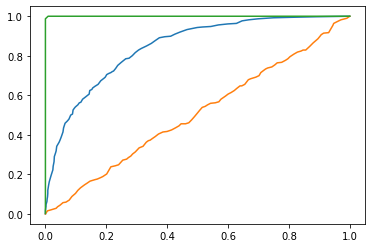

In [47]:
plt.plot(scores_df.fpr, scores_df.tpr, label='actual')
plt.plot(scores_df_random.fpr, scores_df_random.tpr, label='random')
plt.plot(scores_df_ideal.fpr, scores_df_ideal.tpr, label='ideal')

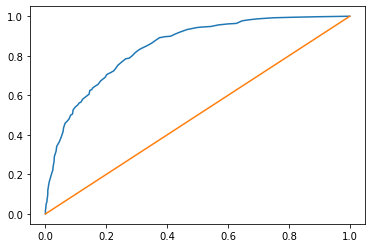

In [48]:
plt.plot(scores_df.fpr, scores_df.tpr, label='actual')
plt.plot([0,1], [0,1], label='random')


In [50]:
from sklearn.metrics import roc_curve

In [54]:
fpr, tpr, thersholds = roc_curve(y_val, y_pred)

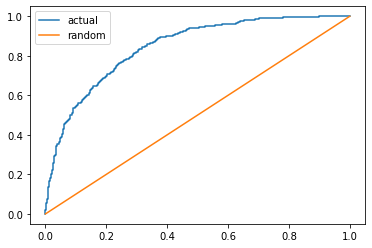

In [56]:
# plt.plot(thresholds, tpr, label='TPR')
# plt.plot(thresholds, fpr, label='FPR')

plt.plot(fpr, tpr, label='actual')
plt.plot([0,1], [0,1], label='random')
plt.legend()

# ROC AUC

In [57]:
from sklearn.metrics import auc

In [58]:
auc(fpr, tpr)

0.8440049838177868

In [59]:
auc(scores_df.fpr, scores_df.tpr)

0.8438340449455275

In [60]:
auc(scores_df_random.fpr, scores_df_random.tpr)

0.5060233793728696

In [61]:
auc(scores_df_ideal.fpr, scores_df_ideal.tpr)

0.9999430203759136

In [62]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8440049838177868

prob(random selected positive) > prob(random selectd negative)

In [67]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

import random

n = 10000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success/n      

0.8435

In [68]:
n = 10000
np.random.seed(1)

pos_idx = np.random.randint(0, len(pos), size=n)
neg_idx = np.random.randint(0, len(neg), size=n)


(pos[pos_idx] > neg[neg_idx]).mean()

0.8407

# Cross Validations

In [93]:
def train(df, columns, y_train, C=1.0):
    dicts = df[columns].to_dict(orient='records')
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)
    
    return dv, model

In [77]:
dv, model = train(df_train, categorical+numerical, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
def predict(df, dv, model, columns):
    dicts = df[columns].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [80]:
y_pred = predict(df_val, dv, model, categorical+numerical)

In [81]:
from sklearn.model_selection import KFold

In [82]:
kfold = KFold(n_splits = 10, shuffle=True, random_state=1)

In [87]:
!pip install tqdm

In [94]:
from tqdm.auto import tqdm
auc_scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, categorical+numerical, y_train, C=10)
    y_pred = predict(df_val, dv, model, categorical+numerical)
    
    
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [95]:
auc_scores

[0.8482737782866594,
 0.8404084158415842,
 0.8557879175456373,
 0.8362686198666777,
 0.8230303970223325,
 0.8342157842157842,
 0.8397590361445785,
 0.8185246679316888,
 0.8431747443308137,
 0.8618869953951127]

In [96]:
np.mean(auc_scores), np.std(auc_scores)

(0.840133035658087, 0.012662617665293504)

In [11]:
from scipy.stats import poisson
import pandas as pd

In [7]:
poisson.rvs(loc=18,mu=30,size=10)

array([37, 40, 46, 48, 49, 41, 50, 51, 45, 49])

In [9]:
poisson.rvs(loc=18,mu=33,size=10)

array([44, 60, 55, 45, 54, 45, 51, 54, 55, 52])

In [12]:
reference = pd.Series([37, 40, 46, 48, 49, 41, 50, 51, 45, 49])
current = pd.Series([44, 60, 55, 45, 54, 45, 51, 54, 55, 52])

In [13]:
from scipy.stats import ttest_ind

In [15]:
p_value = ttest_ind(reference, current)[1]

In [17]:
p_value, p_value < 0.05

(0.017196415500364014, True)

In [18]:
approx(0.0635, abs=1e-3)

NameError: name 'approx' is not defined

In [20]:
!conda install pytest

^C


In [21]:
from pytest import approx

ModuleNotFoundError: No module named 'pytest'

In [22]:
A_1=[30.02, 29.99, 30.11, 29.97, 30.01, 29.99]
A_2=[29.89, 29.93, 29.72, 29.98,30.02, 29.98]

In [23]:
p_value = ttest_ind(A_1, A_2)[1]

In [26]:
p_value, p_value < 0.001

(0.07856577385723071, False)